In [2]:
import random
import math
import matplotlib.pyplot as plt
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import array
import numpy


In [3]:
class Particle:
    def __init__(self, dimension, l_bound, h_bound):

        self.position = [random.uniform(l_bound, h_bound) for _ in range(dimension)]

        vmax = 0.1 * (h_bound - l_bound)
        self.velocity = [random.uniform(-vmax, vmax) for _ in range(dimension)]

        self.p_best = self.position.copy()
        self.g_best = None

        self.fitness = float('inf')
        self.b_fitness = float('inf')


    def calc_new_velocity(self, r1, r2, a_co1, a_co2):

        cog_component = [r1 * a_co1 * (p - x) for p, x in zip(self.p_best, self.position)]

        soc_component = [r2 * a_co2 * (g - x) for g, x in zip(self.g_best, self.position)]

        self.velocity = [v + c + s for v, c, s in zip(self.velocity, cog_component, soc_component)]

    
    def calc_new_position(self, r1, r2, a_co1, a_co2):

        self.calc_new_velocity(r1, r2, a_co1, a_co2)

        self.position = [x + v for x, v in zip(self.position, self.velocity)]
        

In [4]:
def PSO(dimension, fitness, swarm_size, l_bound, h_bound, a_co1, a_co2, max_iter=100):

    rnd = random.Random(0)
    swarm = [Particle(dimension, l_bound, h_bound) for _ in range(swarm_size)]

    best_fitnesses = []

    best_position = None
    best_fitness = float('inf')  # minimize fitness

    for _ in range(max_iter):
        for particle in swarm:
            particle.fitness = fitness(particle.position)

            # Update personal best
            if (particle.p_best is None) or (particle.fitness < particle.b_fitness):
                particle.p_best = particle.position.copy()
                particle.b_fitness = particle.fitness

            # Update global best
            if (best_position is None) or (particle.fitness < best_fitness):
                best_position = particle.position.copy()
                best_fitness = particle.fitness
            

        # Update velocities and positions
        for particle in swarm:
            particle.g_best = best_position.copy()
            r1 = rnd.random()
            r2 = rnd.random()
            particle.calc_new_position(r1, r2, a_co1, a_co2)
        
        # Logs best fitness for logging
        best_fitnesses.append(best_fitness)

    return (best_position, best_fitness, best_fitnesses)


In [5]:
import array
import random
import numpy
from deap import base, creator, tools

def DE(dimension, fitness, swarm_size, l_bound, h_bound, F, CR, max_iter=100):

    # Avoid re-creating creator in the same session
    try:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    except:
        pass
    try:
        creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)
    except:
        pass

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, l_bound, h_bound)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, dimension)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("evaluate", fitness)

    pop = toolbox.population(n=swarm_size)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    # Evaluate initial population
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = (fit,)

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(pop), **record)
    print(logbook.stream)

    # Main DE loop
    for g in range(1, max_iter):
        for k, agent in enumerate(pop):
            # Select three distinct individuals
            a, b, c = toolbox.select(pop)
            y = toolbox.clone(agent)
            j_rand = random.randrange(dimension)
            for i in range(dimension):
                if i == j_rand or random.random() < CR:
                    y[i] = a[i] + F * (b[i] - c[i])
            # Evaluate trial vector
            y.fitness.values = (toolbox.evaluate(y),)
            # Selection: minimize
            if y.fitness.values[0] < agent.fitness.values[0]:
                pop[k] = y

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=g, evals=len(pop), **record)
        print(logbook.stream)

    return logbook, hof


In [6]:
def rosenbrock_fitness(x):
    D = len(x)

    total = 0.0
    
    for i in range(D-1):
        total += 100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2
    return total

def griewank_fitness(x):

    sum_term = sum(xi**2 / 4000 for xi in x)

    prod_term = 1.0

    for i, xi in enumerate(x, start=1):
        prod_term *= math.cos(xi / math.sqrt(i))
    return sum_term - prod_term + 1

In [7]:
def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

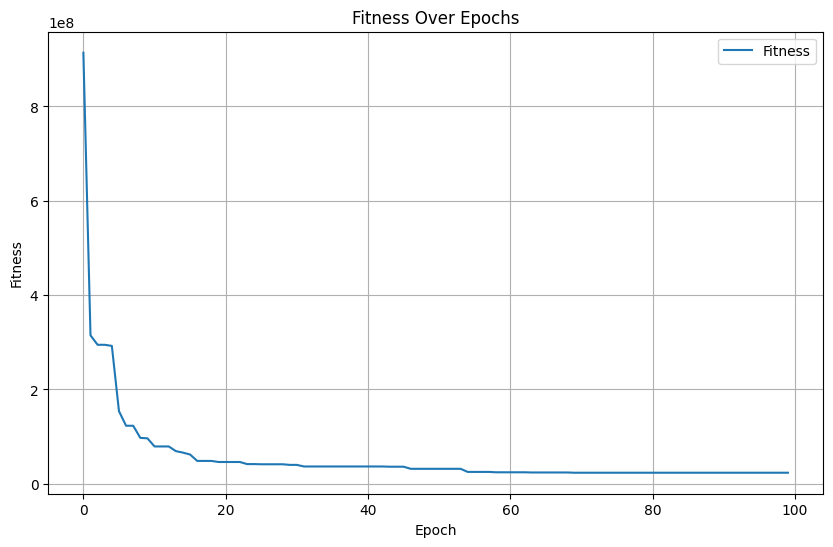

In [8]:
(best_position, best_fitness, best_fitnesses)  = PSO(100,rosenbrock_fitness, 50, -30, 30, 0.5,0.8)

plot_fitness(best_fitnesses)


gen	evals	std        	min        	avg        	max        
0  	50   	2.05905e+08	1.22257e+09	1.59515e+09	1.96417e+09
1  	50   	2.66565e+08	3.86152e+08	1.57153e+09	1.96417e+09
2  	50   	3.11075e+08	3.86152e+08	1.54521e+09	1.96417e+09
3  	50   	3.42732e+08	3.86152e+08	1.52058e+09	1.96417e+09
4  	50   	3.76604e+08	3.86152e+08	1.4723e+09 	1.96417e+09
5  	50   	3.76604e+08	3.86152e+08	1.4723e+09 	1.96417e+09
6  	50   	4.14292e+08	3.86152e+08	1.42231e+09	1.94468e+09
7  	50   	4.65268e+08	3.50841e+08	1.34532e+09	1.93561e+09
8  	50   	4.87537e+08	3.50841e+08	1.26882e+09	1.93561e+09
9  	50   	4.98887e+08	2.8332e+08 	1.15859e+09	1.93561e+09
10 	50   	4.93336e+08	2.09398e+08	1.03591e+09	1.93561e+09
11 	50   	4.86909e+08	1.70831e+08	8.89702e+08	1.93561e+09
12 	50   	4.71207e+08	1.70831e+08	7.70711e+08	1.93561e+09
13 	50   	4.16442e+08	1.59928e+08	6.67078e+08	1.93306e+09
14 	50   	3.32737e+08	1.59928e+08	5.80301e+08	1.45657e+09
15 	50   	2.97182e+08	1.27825e+08	4.97207e+08	1.34324e+09
16 	50   	1.97

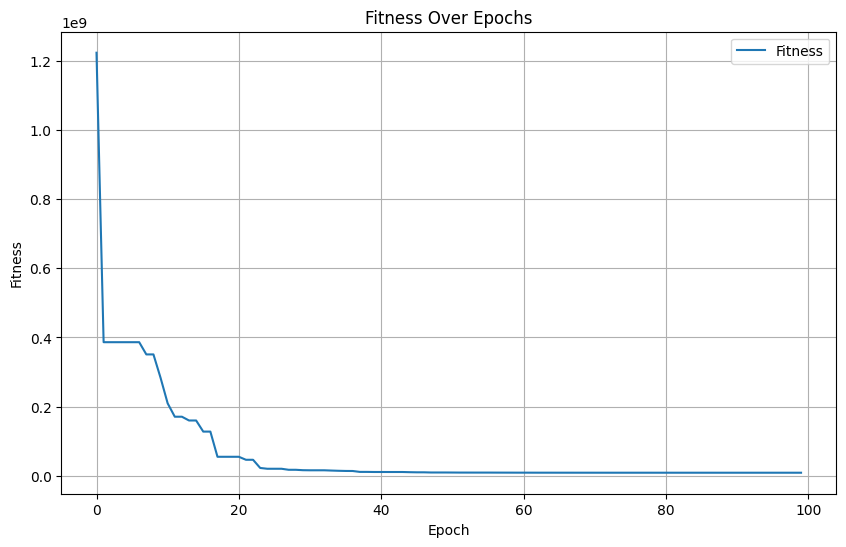

In [ ]:
(logbook,hfa) = DE(50,rosenbrock_fitness, 50, -30, 30, 0.5,1)

best_fitness= logbook.select("min")

fitness_float = [ float(i) for i in best_fitness]
plot_fitness(fitness_float)